<a href="https://colab.research.google.com/github/YeongRoYun/BearTeam/blob/edu/edu/model/YOLOv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!head -n 3 /proc/meminfo

MemTotal:       26692024 kB
MemFree:        23564132 kB
MemAvailable:   25460120 kB


In [2]:
# Colab에서 Drive에 파일 저장하기
import os
from google.colab import drive

drive.mount('/content/gdrive/')
basePath = "/content/gdrive/MyDrive/Colab Notebooks"

# path2data = basePath + '/data/voc'
path2data = '/content/data/voc'
path2model = basePath + '/model'
path2YOLO = path2model + '/yolov1.pt'

if not os.path.exists(path2data): 
    os.makedirs(path2data, exist_ok=True)

if not os.path.exists(path2model):
    os.makedirs(path2model, exist_ok=True)

Mounted at /content/gdrive/


In [3]:
!pip install xmltodict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import VOCDetection


import os
import xmltodict
import numpy as np
from PIL import Image
from tqdm import tqdm

In [5]:
class YOLO_PASCAL_VOC(VOCDetection):
    def __getitem__(self, index):
        """
        전처리
        결과 : 
          X : images : [batch_size, 3(channel), 224(width), 224(height)] shape
          y : labels : [batch_size, 7(S), 7(S), 25(5 + 20)] shape 
                     : 격자마다 하나의 Bounding Box가 예측될 수 있다!
                     : Bounding Box의 Object의 클래스는 Box에 걸쳐있는 물체들의 여러 클래스들 중 하나이다.
                     : 한 격자에 Object의 중심 좌표들이 동시에 포함된 경우, Detection하기 힘들다.
        """
        img = Image.open(self.images[index]).convert('RGB')
        
        img = img.resize((224,224))
        img_transform = transforms.Compose([
            transforms.PILToTensor(),
            transforms.Resize((224,224))
        ])
        img = torch.divide(img_transform(img), 255)
        
        target = xmltodict.parse(open(self.annotations[index], mode='rb'))
        
        classes = ["aeroplane", "bicycle", "bird", "boat", "bottle",
                   "bus", "car", "cat", "chair", "cow", "diningtable",
                   "dog", "horse", "motorbike", "person", "pottedplant",
                   "sheep", "sofa", "train", "tvmonitor"]
        
        label = np.zeros((7, 7, 25), dtype = float)
       
        # Grid 만들기
        Image_Height = float(target['annotation']['size']['height'])
        Image_Width = float(target['annotation']['size']['width'])

        try:
            for i, obj in enumerate(target['annotation']['object']):
                class_index = classes.index(obj['name'].lower())
                
                x_min = float(obj['bndbox']['xmin']) 
                y_min = float(obj['bndbox']['ymin'])
                x_max = float(obj['bndbox']['xmax']) 
                y_max = float(obj['bndbox']['ymax'])
                
                
                # 224 x 224 크기로 Scaling
                x_min = float((224.0/Image_Width)*x_min)
                y_min = float((224.0/Image_Height)*y_min)
                x_max = float((224.0/Image_Width)*x_max)
                y_max = float((224.0/Image_Height)*y_max)
                
                x = (x_min + x_max) / 2.0
                y = (y_min + y_max) / 2.0
                w = x_max - x_min + 1
                h = y_max - y_min + 1
                
                # 7 x 7 Grid!
                x_cell = int(x/32)
                y_cell = int(y/32)
                
                x_val_inCell = float((x - x_cell * 32.0)/32.0)
                y_val_inCell = float((y - y_cell * 32.0)/32.0)
                
                # Bounding Box의 width와 height를 [0,1] 사이의 값으로 정규화 한다.
                w = w / 224.0
                h = h / 224.0
                
                # [x, y, w, h, c] 이후에 Class one-hot encoding이 있으므로, Offset을 5 준다.
                class_index_inCell = class_index + 5
                
                # 한 Cell에서 Bounding Box는 하나만 가진다(Loop의 마지막 box로 update 됨)
                label[y_cell][x_cell][0] = x_val_inCell
                label[y_cell][x_cell][1] = y_val_inCell
                label[y_cell][x_cell][2] = w
                label[y_cell][x_cell][3] = h
                # Object가 있는 것이 확실하므로 Confidence = 1.0이다.
                label[y_cell][x_cell][4] = 1.0
                
                # 하지만, Bounding Box의 Class는 여러 클래스 들 중 하나로 정해진다(가능한 모든 Class가 1로 설정됨)
                label[y_cell][x_cell][class_index_inCell] = 1.0
                
                # 위의 식에서 Bounding Box와 Class의 관계로 인해 겹쳐진 물체를 정확히 탐지하기 힘들다.
    
        # Single-Object in Image
        except TypeError:
            obj = target['annotation']['object']
            class_index = classes.index(obj['name'].lower())
                
            x_min = float(obj['bndbox']['xmin']) 
            y_min = float(obj['bndbox']['ymin'])
            x_max = float(obj['bndbox']['xmax']) 
            y_max = float(obj['bndbox']['ymax'])
            
            

            x_min = float((224.0/Image_Width)*x_min)
            y_min = float((224.0/Image_Height)*y_min)
            x_max = float((224.0/Image_Width)*x_max)
            y_max = float((224.0/Image_Height)*y_max)

            x = (x_min + x_max)/2.0
            y = (y_min + y_max)/2.0
            w = x_max - x_min + 1
            h = y_max - y_min + 1

            x_cell = int(x/32) 
            y_cell = int(y/32) 
            x_val_inCell = float((x - x_cell * 32.0)/32.0) 
            y_val_inCell = float((y - y_cell * 32.0)/32.0)

            w = w / 224.0
            h = h / 224.0

            class_index_inCell = class_index + 5

            label[y_cell][x_cell][0] = x_val_inCell
            label[y_cell][x_cell][1] = y_val_inCell
            label[y_cell][x_cell][2] = w
            label[y_cell][x_cell][3] = h
            label[y_cell][x_cell][4] = 1.0
            label[y_cell][x_cell][class_index_inCell] = 1.0

        return img, torch.tensor(label)
            

In [6]:
BATCH_SIZE = 256
EPOCH = 135

Train_Dataset = YOLO_PASCAL_VOC(path2data, year='2007', image_set='train', download=True)
Test_Dataset = YOLO_PASCAL_VOC(path2data, year='2007', image_set='test', download=True)

data_loader = torch.utils.data.DataLoader(dataset=Train_Dataset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          drop_last=True)

  0%|          | 0/460032000 [00:00<?, ?it/s]

Extracting /content/data/voc/VOCtrainval_06-Nov-2007.tar to /content/data/voc


  0%|          | 0/451020800 [00:00<?, ?it/s]

Extracting /content/data/voc/VOCtest_06-Nov-2007.tar to /content/data/voc


In [7]:
# 순전파 때 float16으로 자료형 지정!
from torch.cuda.amp import autocast

class YOLO(nn.Module):
    def __init__(self, VGG16):
        super().__init__()
        
        self.backbone = VGG16
        
        self.conv = nn.Sequential(
            nn.BatchNorm2d(512), # in_channels
            nn.Conv2d(in_channels = 512,out_channels = 1024, kernel_size = 3, padding = 1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(1024),
            nn.Conv2d(in_channels = 1024,out_channels = 1024, kernel_size = 3, padding = 1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(1024),
            nn.Conv2d(in_channels = 1024,out_channels = 1024, kernel_size = 3, padding = 1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(1024),
            nn.Conv2d(in_channels = 1024,out_channels = 1024, kernel_size = 3, padding = 1),
            nn.LeakyReLU(),
            nn.Flatten()
        )
        self.linear = nn.Sequential(
            nn.BatchNorm1d(7*7*1024),
            nn.Linear(7*7*1024, 4096),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.BatchNorm1d(4096),
            nn.Linear(4096, 1470)
        )

    @autocast()
    def forward(self, x):
        out = self.backbone(x)
        out = self.conv(out)
        out = self.linear(out)

        # B = 2 일 때, YOLOv1은 한 Cell 당 2 개의 Bounding Box를 추측한다.
        # [box1's(x, y, w, h, c), box2's(x, y, w, h, c) ...]
        # 두 예측 중 더 정확한 것을 선택!
        out = torch.reshape(out, (-1 ,7, 7, 30))
        return out

In [8]:
def calculate_custom_loss_for_YOLOv1_v1(y_pred, y_true, device):
    """
    S : 7, B : 2, C : 20
    y_pred : [S x S x (5 * B + C)] shape
    y_true : [S x S x (5 + C)] shape
    Desc.  :
             YOLO는 Class 분류 문제와 Bounding Box Regression을 함께 Regression한다.
             따라서 일반적인 MSE를 사용할 때 부정확하게 Loss가 반영된다.
             Confidence, Class Classification, Bounding Box Regression를 따로 고려한다.
    """
    
    batch_loss = 0
    nb_batches = y_true.size(0)
    for i in range(nb_batches):
        y_true_unit = y_true[i].clone().detach().requires_grad_(True).to(device)
        y_pred_unit = y_pred[i].clone().detach().requires_grad_(True).to(device)
        y_true_unit = torch.reshape(y_true_unit, [49, 25]) # [S x S, B + 20] shape
        y_pred_unit = torch.reshape(y_pred_unit, [49, 30]) # [S x S, 5 x B + 20] shape

        loss = 0.0
        for cell in range(0, y_true_unit.size(0)):
            """
            각 Cell 마다 Loss를 계산한다!
            """
            bbox1_pred = y_pred_unit[cell, 0:4]
            bbox1_pred_confidence = y_pred_unit[cell, 4]
            bbox2_pred = y_pred_unit[cell, 5:9]
            bbox2_pred_confidence = y_pred_unit[cell, 9]
            
            class_pred = y_pred_unit[cell, 10:]
            
            bbox_true = y_true_unit[cell, :4]
            bbox_true_confidence = y_true_unit[cell, 4]
            class_true = y_true_unit[cell, 5:]

            # Box Regression Loss 구하기 : IoU 계산!

            # [min_x, min_y, max_x, max_y] 찾기
            # bboxn_pred = [x, y, w, h] 이다.
            # x, y : Cell 안에서의 상대 좌표!
            # w, h : Bounding Box의 Width와 Height
            box_pred_1_minmax = torch.FloatTensor([0., 0., 0., 0.]).to(device)
            box_pred_1_minmax[:2] = bbox1_pred[:2] - 0.5 * bbox1_pred[2:] # x - 0.5 * w , y - 0.5 * h
            box_pred_1_minmax[2:] = bbox1_pred[:2] + 0.5 * bbox1_pred[2:] # x + 0.5 * w , y + 0.5 * h

            box_pred_2_minmax = torch.FloatTensor([0., 0., 0., 0.]).to(device)
            box_pred_2_minmax[:2] = bbox2_pred[:2] - 0.5 * bbox2_pred[2:] # x - 0.5 * w , y - 0.5 * h
            box_pred_2_minmax[2:] = bbox2_pred[:2] + 0.5 * bbox2_pred[2:] # x + 0.5 * w , y + 0.5 * h

            box_true_minmax = torch.FloatTensor([0., 0., 0., 0.]).to(device)
            box_true_minmax[:2] = bbox_true[:2] - 0.5 * bbox_true[2:]
            box_true_minmax[2:] = bbox_true[:2] + 0.5 * bbox_true[2:]

            # True와의 Intersection Area 구하기
            # 교차된 영역의 x_min, y_min, x_max, y_max를 구한다.
            # 두 Box의 x/y_min 중 큰 것, x/y_max 중 작은 것이 위의 값이다.

            boxes_minmax = torch.stack([box_pred_1_minmax, box_true_minmax], 0).to(device) # [[min_x, min_y, max_x, max_y], [min_x, min_y, max_x, max_y]] 형태
            InterSection_pred_1_with_true = torch.FloatTensor([0., 0., 0., 0.]).to(device)
            InterSection_pred_1_with_true[:2] = torch.max(boxes_minmax[:, :2], dim=0)[0] # max([min_x, min_y], [min_x, min_y], dim=0)
            InterSection_pred_1_with_true[2:] = torch.min(boxes_minmax[:, 2:], dim=0)[0] # min([max_x, max_y], [max_x, max_y], dim=0)

            boxes_minmax = torch.stack([box_pred_2_minmax, box_true_minmax], 0).to(device)
            InterSection_pred_2_with_true = torch.FloatTensor([0., 0., 0., 0.]).to(device)
            InterSection_pred_2_with_true[:2] = torch.max(boxes_minmax[:, :2], dim=0)[0] # max([min_x, min_y], [min_x, min_y], dim=0)
            InterSection_pred_2_with_true[2:] = torch.min(boxes_minmax[:, 2:], dim=0)[0] # min([max_x, max_y], [max_x, max_y], dim=0)

            # x_min >= x_max or y_min >= y_max 라면 서로 교차되지 않는 Bounding Box이다.

            # Intersection 영역 구하기
            IntersectionArea_pred_1_true = 0.0
            width = InterSection_pred_1_with_true[2] - InterSection_pred_1_with_true[0] + 1
            height = InterSection_pred_1_with_true[3] - InterSection_pred_1_with_true[1] + 1
            if width > 0 and height > 0 :
                IntersectionArea_pred_1_true = width * height

            IntersectionArea_pred_2_true = 0.0
            width = InterSection_pred_2_with_true[2] - InterSection_pred_2_with_true[0] + 1
            height = InterSection_pred_2_with_true[3] - InterSection_pred_2_with_true[1] + 1
            if width > 0 and height > 0 :
                IntersectionArea_pred_2_true = width * height
            
            # Union 영역 구하기
            width = box_pred_1_minmax[2] - box_pred_1_minmax[0] + 1
            height = box_pred_1_minmax[3] - box_pred_1_minmax[1] + 1
            box_pred_1_area = width * height

            width = box_pred_2_minmax[2] - box_pred_2_minmax[0] + 1
            height = box_pred_2_minmax[3] - box_pred_2_minmax[1] + 1
            box_pred_2_area = width * height

            width = box_true_minmax[2] - box_true_minmax[0] + 1
            height = box_true_minmax[3] - box_true_minmax[1] + 1
            box_true_area = width * height
            
            UnionArea_pred_1_true = box_pred_1_area + box_true_area - IntersectionArea_pred_1_true
            UnionArea_pred_2_true = box_pred_2_area + box_true_area - IntersectionArea_pred_2_true

            # IoU 구하기
            IoU_box_1 = IntersectionArea_pred_1_true/UnionArea_pred_1_true
            IoU_box_2 = IntersectionArea_pred_2_true/UnionArea_pred_2_true

            # Bounding Box Loss 완성하기
            # 예측한 두 개의 Bounding Box 중 IoU가 더 높은 Box를 반응성 있는 것으로 선택한다.
            # Label을 살펴 실체 Object가 있는 경우, Resonable confidence를 사용하고, 그렇지 않다면 Non-Resonable Confidence를 사용한다.
            responsible_bbox = torch.zeros(4).to(device)
            responsible_bbox_confidence = torch.FloatTensor([0.]).to(device)
            non_responsible_bbox_confidence = torch.FloatTensor([0.]).to(device)

            if IoU_box_1 >= IoU_box_2 :
                responsible_bbox = bbox1_pred
                responsible_bbox_confidence = bbox1_pred_confidence
                non_responsible_bbox_confidence = bbox2_pred_confidence
                                
            else :
                responsible_box = bbox2_pred
                responsible_bbox_confidence = bbox2_pred_confidence
                non_responsible_bbox_confidence = bbox1_pred_confidence
            
            # Cell에 진짜 Object가 있는지 확인!
            # Cell에 
            ## 1. Object의 중심 좌표가 있는지(0, 0에 중심 좌표가 있을 수도 있다!)
            ## 2. Bounding Box의 크기가 표현되어 있는지(0이 아닌지!)
            ## 를 모두 확인한다.
            obj_exist = torch.FloatTensor([1.]).to(device)
            if torch.where(bbox_true == 0.0, True, False).all():
                obj_exist[0] = 0.0

            # Box Localization Loss 구하기!
            ## 1. x, y 중심 좌표는 그냥 차로,
            ## 2. w, h 길이는 제곱근의 차로 구해서 길이의 좌표의 비중을 비슷하게 유지한다.
            localization_err_xy = (bbox_true[:2] - responsible_bbox[:2]) ** 2
            localization_err_wh = (bbox_true[2:] ** 0.5 - responsible_bbox[2:] ** 0.5) ** 2

            ## Loss가 너무 적게/많이 나와서 NaN이 나오는 경우, 0으로 바꾼다!
            localization_err_xy = torch.where(torch.isnan(localization_err_xy), 0.0, localization_err_xy)
            localization_err_wh = torch.where(torch.isnan(localization_err_wh), 0.0, localization_err_wh)
            
            # Bounding Box Loss 완성하기!
            localization_err = torch.sum(localization_err_xy + localization_err_wh, 0)
            
            ## 논문에 나온 가중치 5.0 곱하기
            weighted_localization_err = torch.multiply(localization_err, 5.0)

            ## Object가 있는 경우에만 Bounding Box가 의미 있다. 따라서 Cross-Entropy처럼 계산한다.
            weighted_localization_err = torch.multiply(weighted_localization_err, obj_exist)

            # Confidence Loss 구하기
            class_confidence_score_obj = (responsible_bbox_confidence - bbox_true_confidence) ** 2
            # Object가 있는 경우에 obj_confidence_score가 의미 있다.
            class_confidence_score_obj = torch.multiply(class_confidence_score_obj, obj_exist)
            
            # Object가 없는 경우, Noobj의 confidence_score를 고려하여 Loss를 고려한다.
            # bbox_true_confidence = 0이 들어올 것이다.
            class_confidence_score_noobj = (non_responsible_bbox_confidence - bbox_true_confidence) ** 2
            # 논문에 나온 가중치 .5 곱하기
            class_confidence_score_noobj = torch.multiply(class_confidence_score_noobj, 0.5)
            
            # Object가 없는 경우에 noobj_confidence_score가 의미 있다
            class_confidence_score_noobj = torch.multiply(class_confidence_score_noobj, torch.subtract(torch.ones_like(obj_exist), obj_exist))

            # Confidence Loss 완성하기
            class_confidence_score = torch.add(class_confidence_score_obj,  class_confidence_score_noobj) 

            # Classification Loss 구하기
            classification_err = (class_true - class_pred) ** 2.0
            classification_err = torch.sum(classification_err, 0)
            
            # Classification Loss 완성하기
            ## Object가 있어야 Classification Loss가 의미 있다.
            classification_err = torch.multiply(classification_err, obj_exist)

            # 모든 Loss를 고려한 loss 구하기
            loss_OneCell = weighted_localization_err + class_confidence_score + classification_err

            if loss == 0 :
                loss = loss_OneCell.clone().detach().requires_grad_(True).to(device)
            else :
                loss = torch.add(loss, loss_OneCell)
        

        # Batch의 평균 Loss 구하기!
        if batch_loss == 0:
            batch_loss = loss.clone().detach().requires_grad_(True).to(device)
            batch_loss = torch.divide(batch_loss, nb_batches)
        else:
            batch_loss = torch.add(batch_loss, torch.divide(loss, nb_batches))
    
    return batch_loss

In [9]:
def calculate_custom_loss_for_YOLOv1_v2(y_pred, y_true, device):
    nb_batches = y_true.size(0)

    y_true = torch.reshape(y_true, [nb_batches, 49, 25]).clone().to(device)
    y_pred = torch.reshape(y_pred, [nb_batches, 49, 30]).clone().to(device)

    bbox1_pred = y_pred[..., 0:4]
    bbox1_pred_confidence = y_pred[..., 4]
    bbox2_pred = y_pred[..., 5:9]
    bbox2_pred_confidence = y_pred[..., 9]

    class_pred = y_pred[..., 10:]

    bbox_true = y_true[..., 0:4]
    bbox_true_confidence = y_true[..., 4]
    
    class_true = y_true[..., 5:]

    box_pred_1_min = bbox1_pred[..., 0:2] - 0.5 * bbox1_pred[..., 2:]
    box_pred_1_max = bbox1_pred[..., 0:2] + 0.5 * bbox1_pred[..., 2:]

    box_pred_2_min = bbox2_pred[..., 0:2] - 0.5 * bbox2_pred[..., 2:]
    box_pred_2_max = bbox2_pred[..., 0:2] + 0.5 * bbox2_pred[..., 2:]
    
    box_true_min = bbox_true[..., 0:2] - 0.5 * bbox_true[..., 2:]
    box_true_max = bbox_true[..., 0:2] + 0.5 * bbox_true[..., 2:] 
    
    InterSection_pred_1_with_true = torch.zeros([nb_batches, 49, 4], dtype=torch.float16).to(device)
    InterSection_pred_1_with_true[..., :2] = torch.where(box_pred_1_min > box_true_min, box_pred_1_min, box_true_min)
    InterSection_pred_1_with_true[..., 2:] = torch.where(box_pred_1_max < box_true_max, box_pred_1_max, box_true_max)

    InterSection_pred_2_with_true = torch.zeros([nb_batches, 49, 4], dtype=torch.float16).to(device)
    InterSection_pred_2_with_true[..., :2] = torch.where(box_pred_2_min > box_true_min, box_pred_2_min, box_true_min)
    InterSection_pred_2_with_true[..., 2:] = torch.where(box_pred_2_max < box_true_max, box_pred_2_max, box_true_max)

    width = InterSection_pred_1_with_true[..., 2] - InterSection_pred_1_with_true[..., 0] + 1
    height = InterSection_pred_1_with_true[..., 3] - InterSection_pred_1_with_true[..., 1] + 1

    # 겹치지 않는 영역은 IoU 0 !
    width = torch.where(width > 0.0, width, 0.0)
    height = torch.where(height > 0.0, height, 0.0)

    InterSectionArea_pred_1_true = width * height # [nb_batches, 49, 1]

    width = InterSection_pred_2_with_true[..., 2] - InterSection_pred_2_with_true[..., 0] + 1
    height = InterSection_pred_2_with_true[..., 3] - InterSection_pred_2_with_true[..., 1] + 1

    # 겹치지 않는 영역은 Intersection =  0 !
    width = torch.where(width > 0.0, width, 0.0)
    height = torch.where(height > 0.0, height, 0.0)

    InterSectionArea_pred_2_true = width * height # [nb_batches, 49, 1]

    # Union 구하기
    width = box_pred_1_max[..., 0] - box_pred_1_min[..., 0] + 1
    height = box_pred_1_max[..., 1] - box_pred_1_min[..., 1] + 1
    box_pred_1_area = width * height

    width = box_pred_2_max[..., 0] - box_pred_2_min[..., 0] + 1
    height = box_pred_2_max[..., 1] - box_pred_2_min[..., 1] + 1
    box_pred_2_area = width * height   

    width = box_true_max[..., 0] - box_true_min[..., 0] + 1
    height = box_true_max[..., 1] - box_true_min[..., 1] + 1
    box_true_area = width * height   

    UnionArea_pred_1_true = box_pred_1_area + box_true_area - InterSectionArea_pred_1_true
    UnionArea_pred_2_true = box_pred_2_area + box_true_area - InterSectionArea_pred_2_true

    # [nb_batches, 49, 1]
    IoU_1 = InterSectionArea_pred_1_true / UnionArea_pred_1_true
    IoU_2 = InterSectionArea_pred_2_true / UnionArea_pred_2_true


    responsible_bbox = torch.zeros([nb_batches, 49, 4], dtype=torch.float32).to(device)
    responsible_bbox_confidence = torch.zeros([nb_batches, 49, 1], dtype=torch.float32).to(device)
    non_responsible_bbox_confidence = torch.zeros([nb_batches, 49, 1], dtype=torch.float32).to(device)
    
    obj_exist = torch.ones([nb_batches, 49, 1], dtype=torch.float32).to(device)
    
    default_mask = IoU_1 > IoU_2
    
    responsible_bbox_confidence[default_mask] = bbox1_pred_confidence[default_mask].unsqueeze(1).to(torch.float32)
    non_responsible_bbox_confidence[~default_mask] = bbox2_pred_confidence[~default_mask].unsqueeze(1).to(torch.float32)
    
    # 1D 씩 연산해야 in-place 연산으로 취급되지 않는다.
    responsible_bbox[..., 0][default_mask] = bbox1_pred[..., 0][default_mask].to(torch.float32)
    responsible_bbox[..., 1][default_mask] = bbox1_pred[..., 1][default_mask].to(torch.float32)
    responsible_bbox[..., 2][default_mask] = bbox1_pred[..., 2][default_mask].to(torch.float32)
    responsible_bbox[..., 3][default_mask] = bbox1_pred[..., 3][default_mask].to(torch.float32)

    responsible_bbox[..., 0][~default_mask] = bbox2_pred[..., 0][~default_mask].to(torch.float32)
    responsible_bbox[..., 1][~default_mask] = bbox2_pred[..., 1][~default_mask].to(torch.float32)
    responsible_bbox[..., 2][~default_mask] = bbox2_pred[..., 2][~default_mask].to(torch.float32)
    responsible_bbox[..., 3][~default_mask] = bbox2_pred[..., 3][~default_mask].to(torch.float32)


    # x == 0 and y == 0 and w == 0 and h == 0 => obj_exist = 0
    mask = (bbox_true == 0).all(dim=2) # [nb, 49, 4]
    obj_exist[mask] = 0.0
    localization_err_xy = (bbox_true[..., :2] - responsible_bbox[..., :2]) ** 2

    # sqrt의 대상은 음수이면 안된다!
    eps=1e-10
    responsible_bbox_wh = responsible_bbox[..., 2:]
    true_bbox_wh = bbox_true[..., 2:]

    responsible_bbox_wh = torch.where(responsible_bbox_wh < eps, eps, responsible_bbox_wh)
    true_bbox_wh = torch.where(true_bbox_wh < eps, eps, true_bbox_wh)
    
    localization_err_wh = (responsible_bbox_wh ** 0.5 - true_bbox_wh ** 0.5) ** 2

    localization_err = torch.sum(localization_err_xy + localization_err_wh, dim=2)

    localization_err *= 5.0

    localization_err.unsqueeze_(2)
    localization_err *= obj_exist

    bbox_true_confidence = bbox_true_confidence.unsqueeze(2)
    class_confidence_score_obj = (responsible_bbox_confidence - bbox_true_confidence) ** 2
    class_confidence_score_obj *= obj_exist

    
    class_confidence_score_noobj = (non_responsible_bbox_confidence) ** 2
    class_confidence_score_noobj *= 0.5
    class_confidence_score_noobj.unsqueeze_(2)
    class_confidence_score_noobj *= (torch.ones_like(obj_exist.unsqueeze(2)) - obj_exist.unsqueeze(2))

    class_confidence_score = class_confidence_score_obj + class_confidence_score_noobj.squeeze(3)
    
    classification_err = (class_true - class_pred) ** 2.0
    classification_err = torch.sum(classification_err, dim=2)
    classification_err.unsqueeze_(2)
    classification_err *= obj_exist

    loss = torch.sum(localization_err + class_confidence_score + classification_err, dim=2)
    loss = torch.sum(loss, dim = 1)
    batch_loss = torch.sum(loss, dim = 0) / nb_batches
    return batch_loss

In [10]:
import torch
x = torch.zeros([1]).requires_grad_(True)
y = x ** 2
y.backward()
x.grad

tensor([0.])

Model 저장하고 불러오기!
https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html

In [11]:
import gc
def train_YOLO(YOLO_model, criterion, optimizer, scheduler, epochs, data_loader, best_loss, device) :
    gc.collect() # memory clean

    YOLO_model.train() # Train mode 진입!
    
    pbar = tqdm(range(epochs), desc="training", mininterval=0.01)
    
    for epoch in pbar:
        for inputs, labels in data_loader:

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
             
            outputs = YOLO_model(inputs)
            loss = criterion(outputs, labels, device)
            loss.backward()
            optimizer.step()

            # 배치로 학습시킬 때마다 loss 보여주기
            pbar_str = "training, [loss = %.4f]" % loss.item()
            pbar.set_description(pbar_str)
            
            # Save best model
            if loss.item() < best_loss:
                best_loss = loss.item()
                torch.save({
                            'epoch': EPOCH,
                            'model_state_dict': YOLO_model.state_dict(),
                            # 'optimizer_state_dict': optimizer.state_dict(),
                            'loss': best_loss,
                            }, path2YOLO)
        # lr decay
        scheduler.step()
    
    # Return None
    print("학습 끝!!!!!!!!")
    return None

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [13]:
import gc
gc.collect()

200

In [14]:
VGGNet = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)


for i in range(len(VGGNet.features[:-1])) :
    if type(VGGNet.features[i]) == type(nn.Conv2d(64,64,3)) :
        VGGNet.features[i].weight.requires_grad = False
        VGGNet.features[i].bias.requires_grad = False
        VGGNet.features[i].padding = 1

backbone = VGGNet.features[:-1]
YOLO_model =  YOLO(backbone).to(device) # Create YOLO model
optimizer = torch.optim.Adam(YOLO_model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0.001)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [15]:
best_loss = float('inf')
gc.collect()
if os.path.exists(path2YOLO):
  print('Load Model...')
  checkpoint = torch.load(path2YOLO)
  YOLO_model.load_state_dict(checkpoint['model_state_dict'])
  ## 이거 뭔지 확인하자!!!!! 로스 관련되서 문제가 생길 수 있따.
  # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  EPOCH = EPOCH - checkpoint['epoch']
  best_loss = checkpoint['loss']
  checkpoint = None

EPOCH = 300
train_YOLO(YOLO_model, calculate_custom_loss_for_YOLOv1_v2, optimizer, scheduler, EPOCH, data_loader, best_loss, device)

Load Model...


training, [loss = 1.9782]: 100%|██████████| 300/300 [2:16:23<00:00, 27.28s/it]

학습 끝!!!!!!!!


In [81]:
# https://wolfy.tistory.com/259
from operator import itemgetter, attrgetter

def getIOU(box1, box2):
    """
    box : [x, y, w, h]
    """
    x, y, w, h = box1
    box1_x_min = x - 0.5 * w
    box1_x_max = x + 0.5 * w
    box1_y_min = y - 0.5 * h
    box1_y_max = y + 0.5 * h
    
    x, y, w, h = box2
    box2_x_min = x - 0.5 * w
    box2_x_max = x + 0.5 * w
    box2_y_min = y - 0.5 * h
    box2_y_max = y + 0.5 * h
    
    intersection_x_min = max(box1_x_min, box2_x_min)
    intersection_x_max = min(box1_x_max, box2_x_max)
    intersection_y_min = max(box1_y_min, box2_y_min)
    intersection_y_max = min(box1_y_max, box2_y_max)
    
    intersection_w = intersection_x_max - intersection_x_min + 1
    intersection_h = intersection_y_max - intersection_y_min + 1
    
    # 겹치는지 판단하기
    if intersection_w > 0 and intersection_h > 0:
        intersectionArea = intersection_w * intersection_h
        box1Area = box1[2] * box1[3]
        box2Area = box2[2] * box2[3]
        unionArea = box1Area + box2Area - intersectionArea
        return intersectionArea
    else:
        return 0.0 # 겹치지 않으면, 0!

def applyNonMaximumSupression(boxes, labels, confidences, class_scores):
    """
    boxes: [tensor([x, y, w, h]), ...]
    labels: [tensor([class]), ...]
    confidences: [tensor([conf]), ...]
    class_scores: [tensor([score]), ...]
    
    Algo:
        1. confidence_threshold 이하의 box 제거
        2. confidence 순서로 정렬(높은 것부터!)
        3. 가장 높은 confidence를 가진 box와 IOU가 threshold보다 큰 box 제거!
        4. 2 - 3 을 반복(더 이상 제거되는 박스가 없을 때까지)
    """
    confidence_threshold = 0.5
    iou_threshold = 0.5
    
    data = list(zip(boxes, labels, confidences, class_scores))

    data = list(filter(lambda datum: datum[2] > confidence_threshold, data))
    data = sorted(data, key=itemgetter(2), reverse = True)
    result = []
    while len(data) > 0:
        highest = data[0]
        result.append(highest)
        data = list(filter(lambda datum: getIOU(highest[0], datum[0]) < iou_threshold, data[1:]))
        
    boxes, labels, confidences, class_scores = list(zip(*result))
    
    boxes = torch.stack(boxes, 0)
    labels = torch.stack(labels, 0)
    confidences = torch.stack(confidences)
    class_scores = torch.stack(class_scores)
    return boxes, labels, confidences, class_scores
        
    
def decode(y_pred):
    """
    y_pred : [S x S x (B x 5 + C)] shape
             B : [x, y, w, h, c, classes]
    
    Returns :
        boxes : [[x_center, y_center, w, h] for obj1, ...]
               [n_boxes, 4] shape 
        labels : class label!
                [n_boxes, ] shape
        confidences : objectness confidence
                      [n_boxes, ] shape
        class_score : scores for class
                      [n_boxes, ] shape
    
    Docs:
        최대 S x S 개의 Bounding Box를 찾을 수 있다!
        격자 하나 당 하나의 Bounding Box가 예측된다.
    """
    S = 7
    B = 2
    C = 20
    
    prob_threshold = 0.5
        
    boxes, labels, confidences, class_scores = [], [], [], []
    
    confidence = torch.zeros([S, S, B])
    for b in range(B):
      confidence[..., b] = y_pred[..., 5*b + 4]
    
    for y_cell in range(S):
        for x_cell in range(S):
            class_score, class_label = torch.max(y_pred[y_cell, x_cell, 5*B:], 0)

            for b in range(B):
                probability = confidence[y_cell, x_cell, b] * class_score
                
                if float(probability) < prob_threshold:
                    continue
                else:
                    x, y, w, h = y_pred[y_cell, x_cell, 5*b : 5*b + 4]
                    
                    # 실제 x, y 좌표 구하기
                    x = 32.0 * (x + x_cell)
                    y = 32.0 * (y + y_cell)
                    
                    # 실제 w, h 좌표 구하기
                    w = w * 224.0
                    h = h * 224.0
                    
                    boxes.append(torch.FloatTensor([x, y, w, h]))
                    labels.append(torch.FloatTensor([class_label]))
                    confidences.append(torch.FloatTensor(confidence[y_cell, x_cell, b]))
                    class_scores.append(torch.FloatTensor([class_score]))
        
        
    if len(boxes) > 0:
        # NMS 고려하기
        boxes, labels, confidences, class_scores = applyNonMaximumSupression(boxes, labels, confidences, class_scores)
    else:
        # No Bounding Box
        boxes = torch.FloatTensor(0, 4)
        labels = torch.FloatTensor(0)
        confidences = torch.FloatTensor(0)
        class_scores = torch.FloatTensor(0)
    
    boxes = boxes.to('cpu')
    labels = labels.to('cpu')
    confidences = confidences.to('cpu')
    class_scores = class_scores.to('cpu')
      
    return boxes, labels, confidences, class_scores



In [71]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def detect(YOLO_model, x, device):
    """
    x : [3 x 224 x 224] 크기의 Image
    
    Returns:
        {
            img: input image
            bbox: [n_boxes, 4] tensor
            labels: [n_boxes, ] tensor
            confidences = [n_boxes, ] tensor
            class_scores = [n_boxes, ] tensor
        }
    """
    
    out = dict()
    img = x.clone().detach().transpose(0, 1).transpose(1, 2) # [224 x 224 x 3]
    
    YOLO_model.eval()
    with torch.no_grad():
        y_pred = YOLO_model(x.unsqueeze(0).to(device))
        boxes, labels, confidences, class_scores = decode(y_pred.squeeze(0))
        
        out = {
            'img': img, 
            'bbox': boxes,
            'labels': labels,
            'confidences': confidences,
            'class_scores': class_scores
        }
    return out

def draw(obj):
    """
    obj : {
        img: input image(RGB)
        bbox: [n_boxes, 4] tensor
        labels: [n_boxes, ] tensor
        confidences = [n_boxes, ] tensor
        class_scores = [n_boxes, ] tensor
    }
    """
    classes = ["aeroplane", "bicycle", "bird", "boat", "bottle",
           "bus", "car", "cat", "chair", "cow", "diningtable",
           "dog", "horse", "motorbike", "person", "pottedplant",
           "sheep", "sofa", "train", "tvmonitor"]
    
    plt.title("YOLOv1")
    plt.imshow(obj['img'])
    ax = plt.gca()
    
    for idx, (x, y, w, h) in enumerate(obj['bbox']):
        x_min = x - w * 0.5
        y_min = y - h * 0.5
        
        x_max = x + w * 0.5
        y_max = y + h * 0.5

        if x_min >= 0 and y_min >= 0 and w > 0 and h > 0:
            rect = patches.Rectangle((x_min, y_min),
                        w,
                        h,
                        linewidth=2,
                        edgecolor='red',
                        fill=False,)
            ax.add_patch(rect)
            plt.annotate(f"{classes[obj['labels'][idx].to(torch.int32)]} {obj['class_scores'][idx].item():.2f}", (x, y))
    plt.show()
        

bset loss: 1.723726


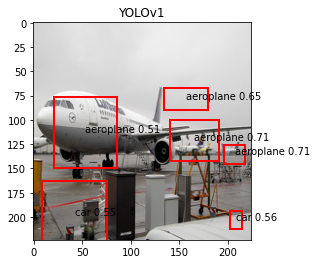

In [83]:
# 예측해보기
assert os.path.exists(path2YOLO)

checkpoint = torch.load(path2YOLO)
YOLO_model.load_state_dict(checkpoint['model_state_dict'])
EPOCH = EPOCH - checkpoint['epoch']
best_loss = checkpoint['loss']
print(f'bset loss: {best_loss:2f}')

img, label = Train_Dataset[5]

out = detect(YOLO_model, img, device)

y_pred = YOLO_model(img.unsqueeze(0).to(device))

draw(out)
